## 1. Initialisation de Spark et chargement des données

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spam-detection-app").getOrCreate()
data = "data/DataSet_Emails.csv"
df = spark.read.csv(data,header=True,inferSchema=True,multiLine=True,escape='"')
df.show(200)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/28 15:14:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/28 15:14:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|  4|     15880|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
|  5|     15726|emerging growth s...|    1|      spam|emerging growth s...|vera ,\nvcsc - br...|2005-01-18|
|  6|     21384|internet pro

25/11/28 15:14:45 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///src/data/DataSet_Emails.csv


## 2. Exploration du schéma et sélection des colonnes

In [2]:
df.printSchema()
df.cache()
df.count() 
df = df.select("text", "label")


root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



25/11/28 15:15:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , message_id, text, label, label_text, subject, message, date
 Schema: _c0, message_id, text, label, label_text, subject, message, date
Expected: _c0 but found: 
CSV file: file:///src/data/DataSet_Emails.csv


## 3. Détection des valeurs nulles

In [3]:
from pyspark.sql import functions as f

for i in df.columns:
    count_null = df.filter(df[i].isNull()).count()
    print(f"{i} : {count_null} valeurs nulles")    

text : 51 valeurs nulles
label : 0 valeurs nulles


## 4. Suppression des valeurs nulles

In [4]:
df = df.na.drop(subset=["text"])

## 5. Comptage des emails spam et non-spam

In [5]:
count_spam_emails = df.filter(f.col("label_text")=="spam").count()
count_not_spam_email = df.filter(f.col("label_text")=="ham").count()
print(f"spam emails = {count_spam_emails}")
print(f"not spam emails = {count_not_spam_email}")

spam emails = 16112
not spam emails = 15553


## 6. Visualisation de la distribution des labels

<Axes: xlabel='label', ylabel='count'>

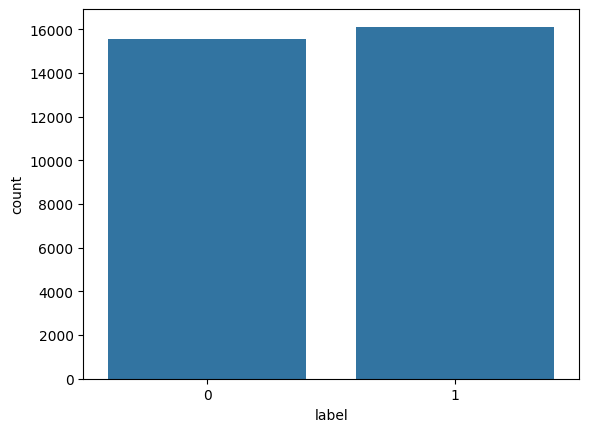

In [6]:
df1 = df.toPandas()
import pandas as pd
import matplotlib.pyplot as mpt
import seaborn as sbn

sbn.countplot(data=df1,x="label")


## 7. Préparation des données pour les nuages de mots

In [7]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import string
import nltk
import matplotlib.pyplot as plt
import pandas as pd

nltk.download('stopwords')

spam_df = df.filter(f.col("label")==1)
spam_text = spam_df.select("text")
spam_list = spam_text.rdd.map(lambda row:row["text"]).collect()

not_spam_df = df.filter(f.col("label")==0)
not_spam_text = not_spam_df.select("text")
not_spam_list = not_spam_text.rdd.map(lambda row:row["text"]).collect()

spam_text_blob = " ".join(spam_list)
not_spam_text_blob = " ".join(not_spam_list)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 8. Génération du nuage de mots pour les emails spam

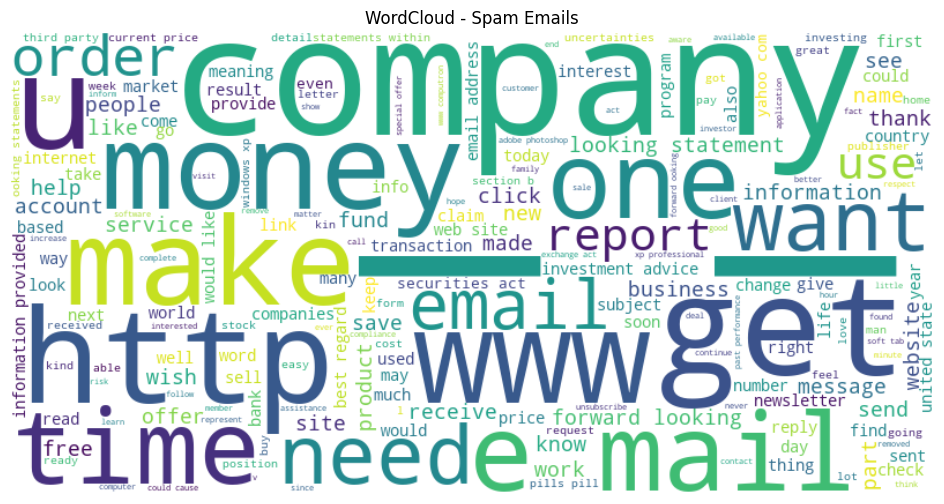

In [8]:
wordcloud_spam = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(stopwords.words('english'))
).generate(spam_text_blob)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Spam Emails")
plt.show()


## 9. Génération du nuage de mots pour les emails non-spam (ham)

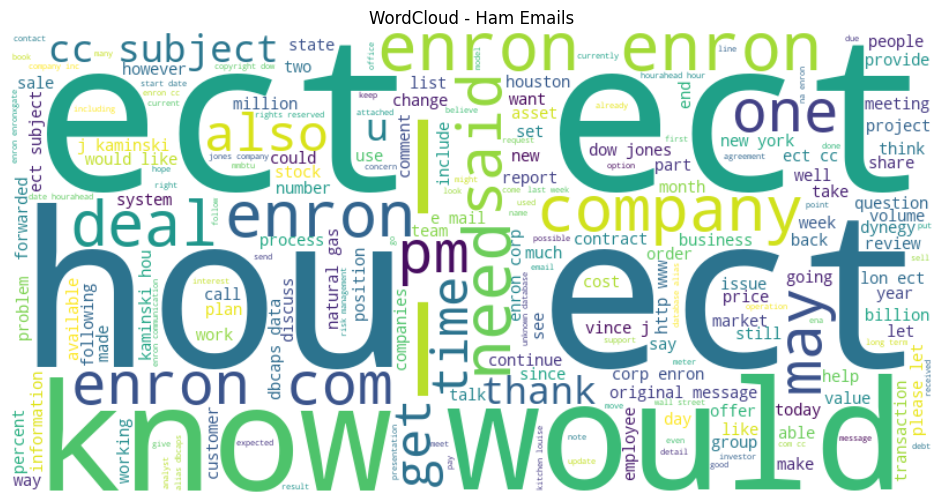

In [9]:
wordcloud_ham = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(stopwords.words('english'))
).generate(not_spam_text_blob)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Ham Emails")
plt.show()


## 10. Conversion du texte en minuscules

In [10]:
spam_list = [text.lower() for text in spam_list]
not_spam_list = [text.lower() for text in not_spam_list]

## 11. Suppression des doublons et filtrage des textes vides

In [11]:
df = df.dropDuplicates()
df = df.filter(f.length(f.col("text")) > 0)


## 12. Nettoyage du texte (suppression des caractères spéciaux)

In [12]:
df_clean = df.withColumn(
    "text_clean",
    f.lower(f.regexp_replace(f.col("text"), "[^a-zA-Z ]", " "))
)

## 13. Tokenisation du texte

In [13]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")
df_tokens = tokenizer.transform(df_clean)

## 14. Suppression des mots vides (stop words)

In [14]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = remover.transform(df_tokens)


## 15. Stemming avec PorterStemmer dans PySpark

In [15]:
from nltk.stem import PorterStemmer

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

ps = PorterStemmer()

def stem_tokens(tokens):
    result = []
    for t in tokens:
        result.append(ps.stem(t))
    return result

# 5. Transformer la fonction en udf pour PySpark
stem_udf = udf(stem_tokens, ArrayType(StringType()))

df_stemmed = df_filtered.withColumn("stemmed_tokens", stem_udf("filtered_tokens"))


In [16]:
df_stemmed.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                text|label|          text_clean|              tokens|     filtered_tokens|      stemmed_tokens|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|weekly report - 1...|    0|weekly report    ...|[weekly, report, ...|[weekly, report, ...|[weekli, report, ...|
|real options conf...|    0|real options conf...|[real, options, c...|[real, options, c...|[real, option, co...|
|iso share ( pnob ...|    0|iso share   pnob ...|[iso, share, , , ...|[iso, share, , , ...|[iso, share, , , ...|
|organizational an...|    0|organizational an...|[organizational, ...|[organizational, ...|[organiz, announc...|
|additional info d...|    0|additional info d...|[additional, info...|[additional, info...|[addit, info, dea...|
|draft doorstep bu...|    0|draft doorstep bu...|[draft, doorstep,...|[draft, doorstep,...|[draf

## 16. HashingTF (transforme les tokens en nombres)

In [17]:
from pyspark.ml.feature import HashingTF, IDF

hashing_tf = HashingTF(
    inputCol="stemmed_tokens",
    outputCol="rawFeatures",
    numFeatures=1000
)

df_tf = hashing_tf.transform(df_stemmed)

idf = IDF(inputCol="rawFeatures", outputCol="tfidfFeatures")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)


## 17. Entraînement de différents modèles de classification et analyse de leurs performances

In [18]:
train_df, test_df = df_tfidf.randomSplit([0.8, 0.2], seed=42)

In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="tfidfFeatures",
    labelCol="label"
)

lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)


25/11/28 15:17:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/11/28 15:17:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
